# Predicting High-Playtime Minecraft Players with K-NN Regression for Recruitment

## Introduction
### Background

In many research studies that rely on human participants, recruiting and managing large groups of people can be a resource-intensive process. This is especially true in data-centric studies where the goal is to collect behavioural data, such as gameplay activity on a video game server. In this case, a research team at UBC is collecting data from players on a Minecraft server to study player behaviour patterns. However, not all players contribute equal amounts of data. Some players play extensively while others participate only briefly, providing relatively small amounts of data in comparison.

Building models that can help predict which types of players are likely to generate larger amounts of data allows researchers to target their recruitment efforts more efficiently. This can reduce time and costs while maximizing the quantity of collected data. If researchers can recruit players who are likely to contribute more gameplay data, they may not need as many participants overall.

In this project, I will examine how age, as well as a gameplay experience, can be used to predict how many game-play hours a player (and potential participant in our study) are likely to generate, and therefore, how much data they will generate. For this model, I will use a K-Nearest Neighbors Regression model.

### The Research Question

The broad research question provided by the research team is the following:  
*"Which kinds of players are most likely to contribute a large amount of data?"*

The specific research question I will be answering is: 
*"Can we use player experience and age to predict the playtime of a new, potential participant?"*

By focusing on this question, I will explore how player age and experience may be related to the amount of gameplay data each person contributes. Since the research team is collecting in-game action logs, players who spend more time on the server naturally generate more gameplay data for researchers. So, it would be beneficial for researchers to seek out high-playtime participants, who will spend more time on the server, and thus, generate more data for them. In this project, I will use the existing data  in the `players.csv` dataset to train a regression model. This model will allow us to predict, based on a new player's characteristics, whether they are going to play few hours ore many hours on the server.


### Data Description

Before starting the analysis, we first need to load the necessary R packages that will allow us to work with the data.

- **tidyverse** — for data wrangling, reading files, cleaning variables, and visualizing data.
- **tidymodels** — for building and evaluating classification models later on



In [1]:
library(tidyverse) 
library(tidymodels) 
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Now that the packages are loaded, we can read in our dataset and begin exploring its structure. This will help us better understand the variables, the number of observations, and any potential issues in the data before we move on to building the model. I will also use the X function to count the total columns and rows this data has, as well as the Y function to get some summary statistics on our data.

In [2]:
players_data<-read_csv("players (1).csv")
players_data

n_rows <- nrow(players_data)
n_cols <- ncol(players_data)
n_rows
n_cols


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] 196

[1] 7

### Data set summary

The `players.csv` dataset contains information about individual players on the Minecraft research server. Below are the key characteristics of this dataset.

**1. Variables**: This dataset includes player demographic information, experience level, total playtime, and subscription status, all held within their respective columns.
- **experience**: The player's experience level, recorded as one of five categories: `Beginner`, `Amateur`, `Regular`, `Veteran`, or `Pro`.
- **subscribe**: Whether the player has subscribed to a game-related newsletter. Recorded as `TRUE` or `FALSE`.
- **hashedEmail**: An anonymized unique identifier for each player. This variable is not used in the analysis.
- **played_hours**: The total number of hours each player has spent playing on the Minecraft server.
- **name**: The player’s first name. This variable is not used in the analysis.
- **gender**: The player’s gender. Categories include `Male`, `Female`, `Non-binary`, and `Prefer not to say`.
- **Age**: The player’s age in years.

**2. Rows and Columns**:  
Using `nrow()` and `ncol()`, I found that this dataset contains **196 observations** and **7 columns**.

**3. Issues with the Data**:
- The variables `name` and `hashedEmail` are not relevant to the research question and will be excluded from the analysis.
- There are no missing values in any of the variables that will be used for modelling.
- The variable `high_playtime` does not currently exist. I will be creating this variable during data wrangling based on the `played_hours` variable.


### Methods & Results

Now that we understand our data set, let’s tidy and wrangle it for ease of use. As mentioned, we only need the age and experience predictors, so let’s select for those columns. We also need the played_hours column, as that is what we are predicting for a new observation. 

In [3]:
# Select only the relevant columns for the analysis
players_selected <- players_data |>
  select(experience, played_hours, Age)

players_selected

experience,played_hours,Age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
⋮,⋮,⋮
Amateur,0.0,17
Amateur,2.3,17
Pro,0.2,NA


One important step before continuing to build our KNN regression model is converting the experience column into numerical values. Currently, these values are characters. This step is necessary because KNN regression requires all predictors to be numeric. In the next step, I will convert the experience column from a character into a numeric scale ranging from 0 to 1.

In [4]:
# first turn experience into a factor so that we can convert it into numbers
players_selected <- players_selected |> 
  mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")))

# now convert experience factor into numbers (on a 1 to 5 scale)
players_selected <- players_selected |> 
  mutate(experience_num = as.numeric(experience))

# now convert again to be in a 0-1 scale
players_selected <- players_selected |> 
  mutate(experience_num = (experience_num - 1) / 4)

# rearranged columns
players_selected <- players_selected |> 
  select(experience_num, Age, played_hours)

players_selected

experience_num,Age,played_hours
<dbl>,<dbl>,<dbl>
1.00,9,30.3
0.75,17,3.8
0.75,17,0.0
⋮,⋮,⋮
0.25,17,0.0
0.25,17,2.3
1.00,NA,0.2


Great! Now we have 2 numerical predictors for our knn regression. Lets vizualize the relationship between our two predictors and the played_hours variable.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


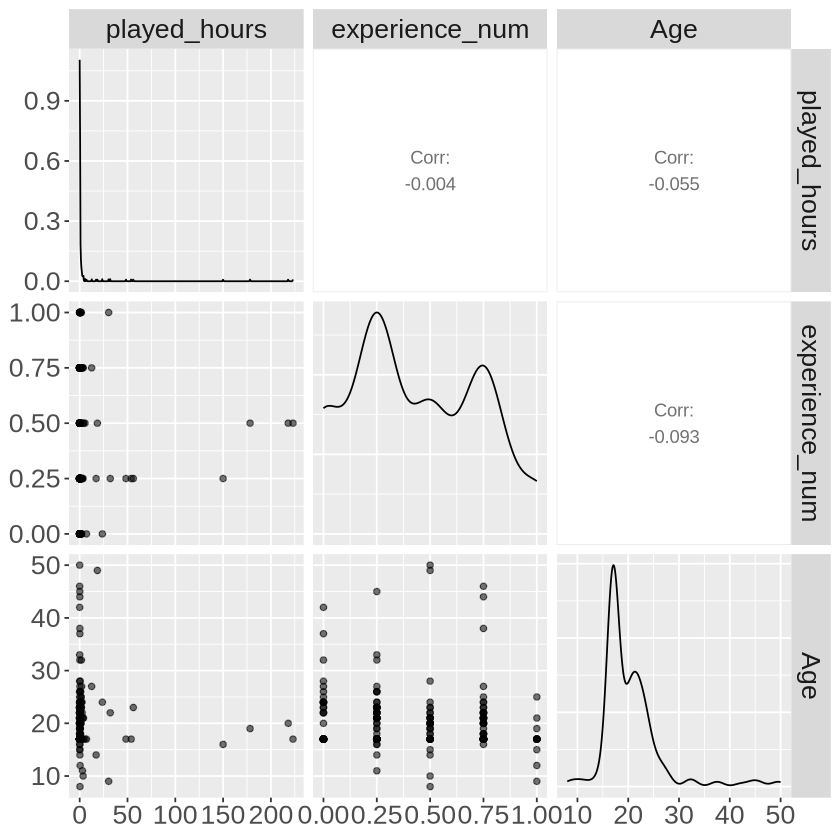

In [8]:

players_for_plot <- players_selected |> 
  select(played_hours, experience_num, Age)


pair_plot <- players_for_plot |> 
  ggpairs(mapping = aes(alpha = 0.4)) +
  theme(text = element_text(size = 20))

pair_plot

To explore the relationships between the variables, I generated a pair plot that includes played_hours, experience_num, and Age. Based on the plots, there do not appear to be strong linear relationships between the predictors (experience_num and Age) and the response variable (played_hours). The correlation coefficients are all very close to zero, suggesting little to no clear association. While some weak patterns may exist, the relationships between both predictors and the outcome are generally unclear and may be influenced by other factors not captured in the data. Lets keep building our knn regression model in the next few steps, now that we better understand our predictors. 